This is an example of developing a script locally with the West Nile Virus data to share on Kaggle
Once you have a script you're ready to share, paste your code into a [new script](https://www.kaggle.com/c/predict-west-nile-virus/scripts/new).

In [577]:
# For working locally, you want to be in west_nile_scripts/working. 
# This command will move you to there, if you're in west_nile_scripts/src (where this file is).
!cd ../working/ # Not necessary for scripts running on Kaggle

In [578]:
# Code is borrowed from: https://www.kaggle.com/users/213536/vasco/predict-west-nile-virus/west-nile-heatmap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
#Remove this when copying to a script on Kaggle:
%matplotlib inline
import datetime as dt
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

In [579]:


mapdata = np.loadtxt("../input/mapdata_copyright_openstreetmap_contributors.txt")
traps = pd.read_csv('../input/train.csv')[['Date', 'Species','Trap','Longitude', 'Latitude', 
                                           'NumMosquitos','WnvPresent']]
weather = pd.read_csv('../input/weather.csv').drop(["CodeSum", "Depth", "Water1", "SnowFall",
                                                    "SeaLevel", "ResultDir", "ResultSpeed",
                                                    "AvgSpeed", "StnPressure"], 1)
spray = pd.read_csv('../input/spray.csv')
samplesub = pd.read_csv('../input/sampleSubmission.csv')
test = pd.read_csv('../input/test.csv')

# aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
# lon_lat_box = (-88, -87.5, 41.6, 42.1)

# plt.figure(figsize=(10,14))
# plt.imshow(mapdata, 
#            cmap=plt.get_cmap('gray'), 
#            extent=lon_lat_box, 
#            aspect=aspect)

# locations = traps[['Longitude', 'Latitude']].drop_duplicates().values
# plt.scatter(locations[:,0], locations[:,1], marker='x')

# Add this when copying to a script on Kaggle:
#plt.savefig('heatmap.png')

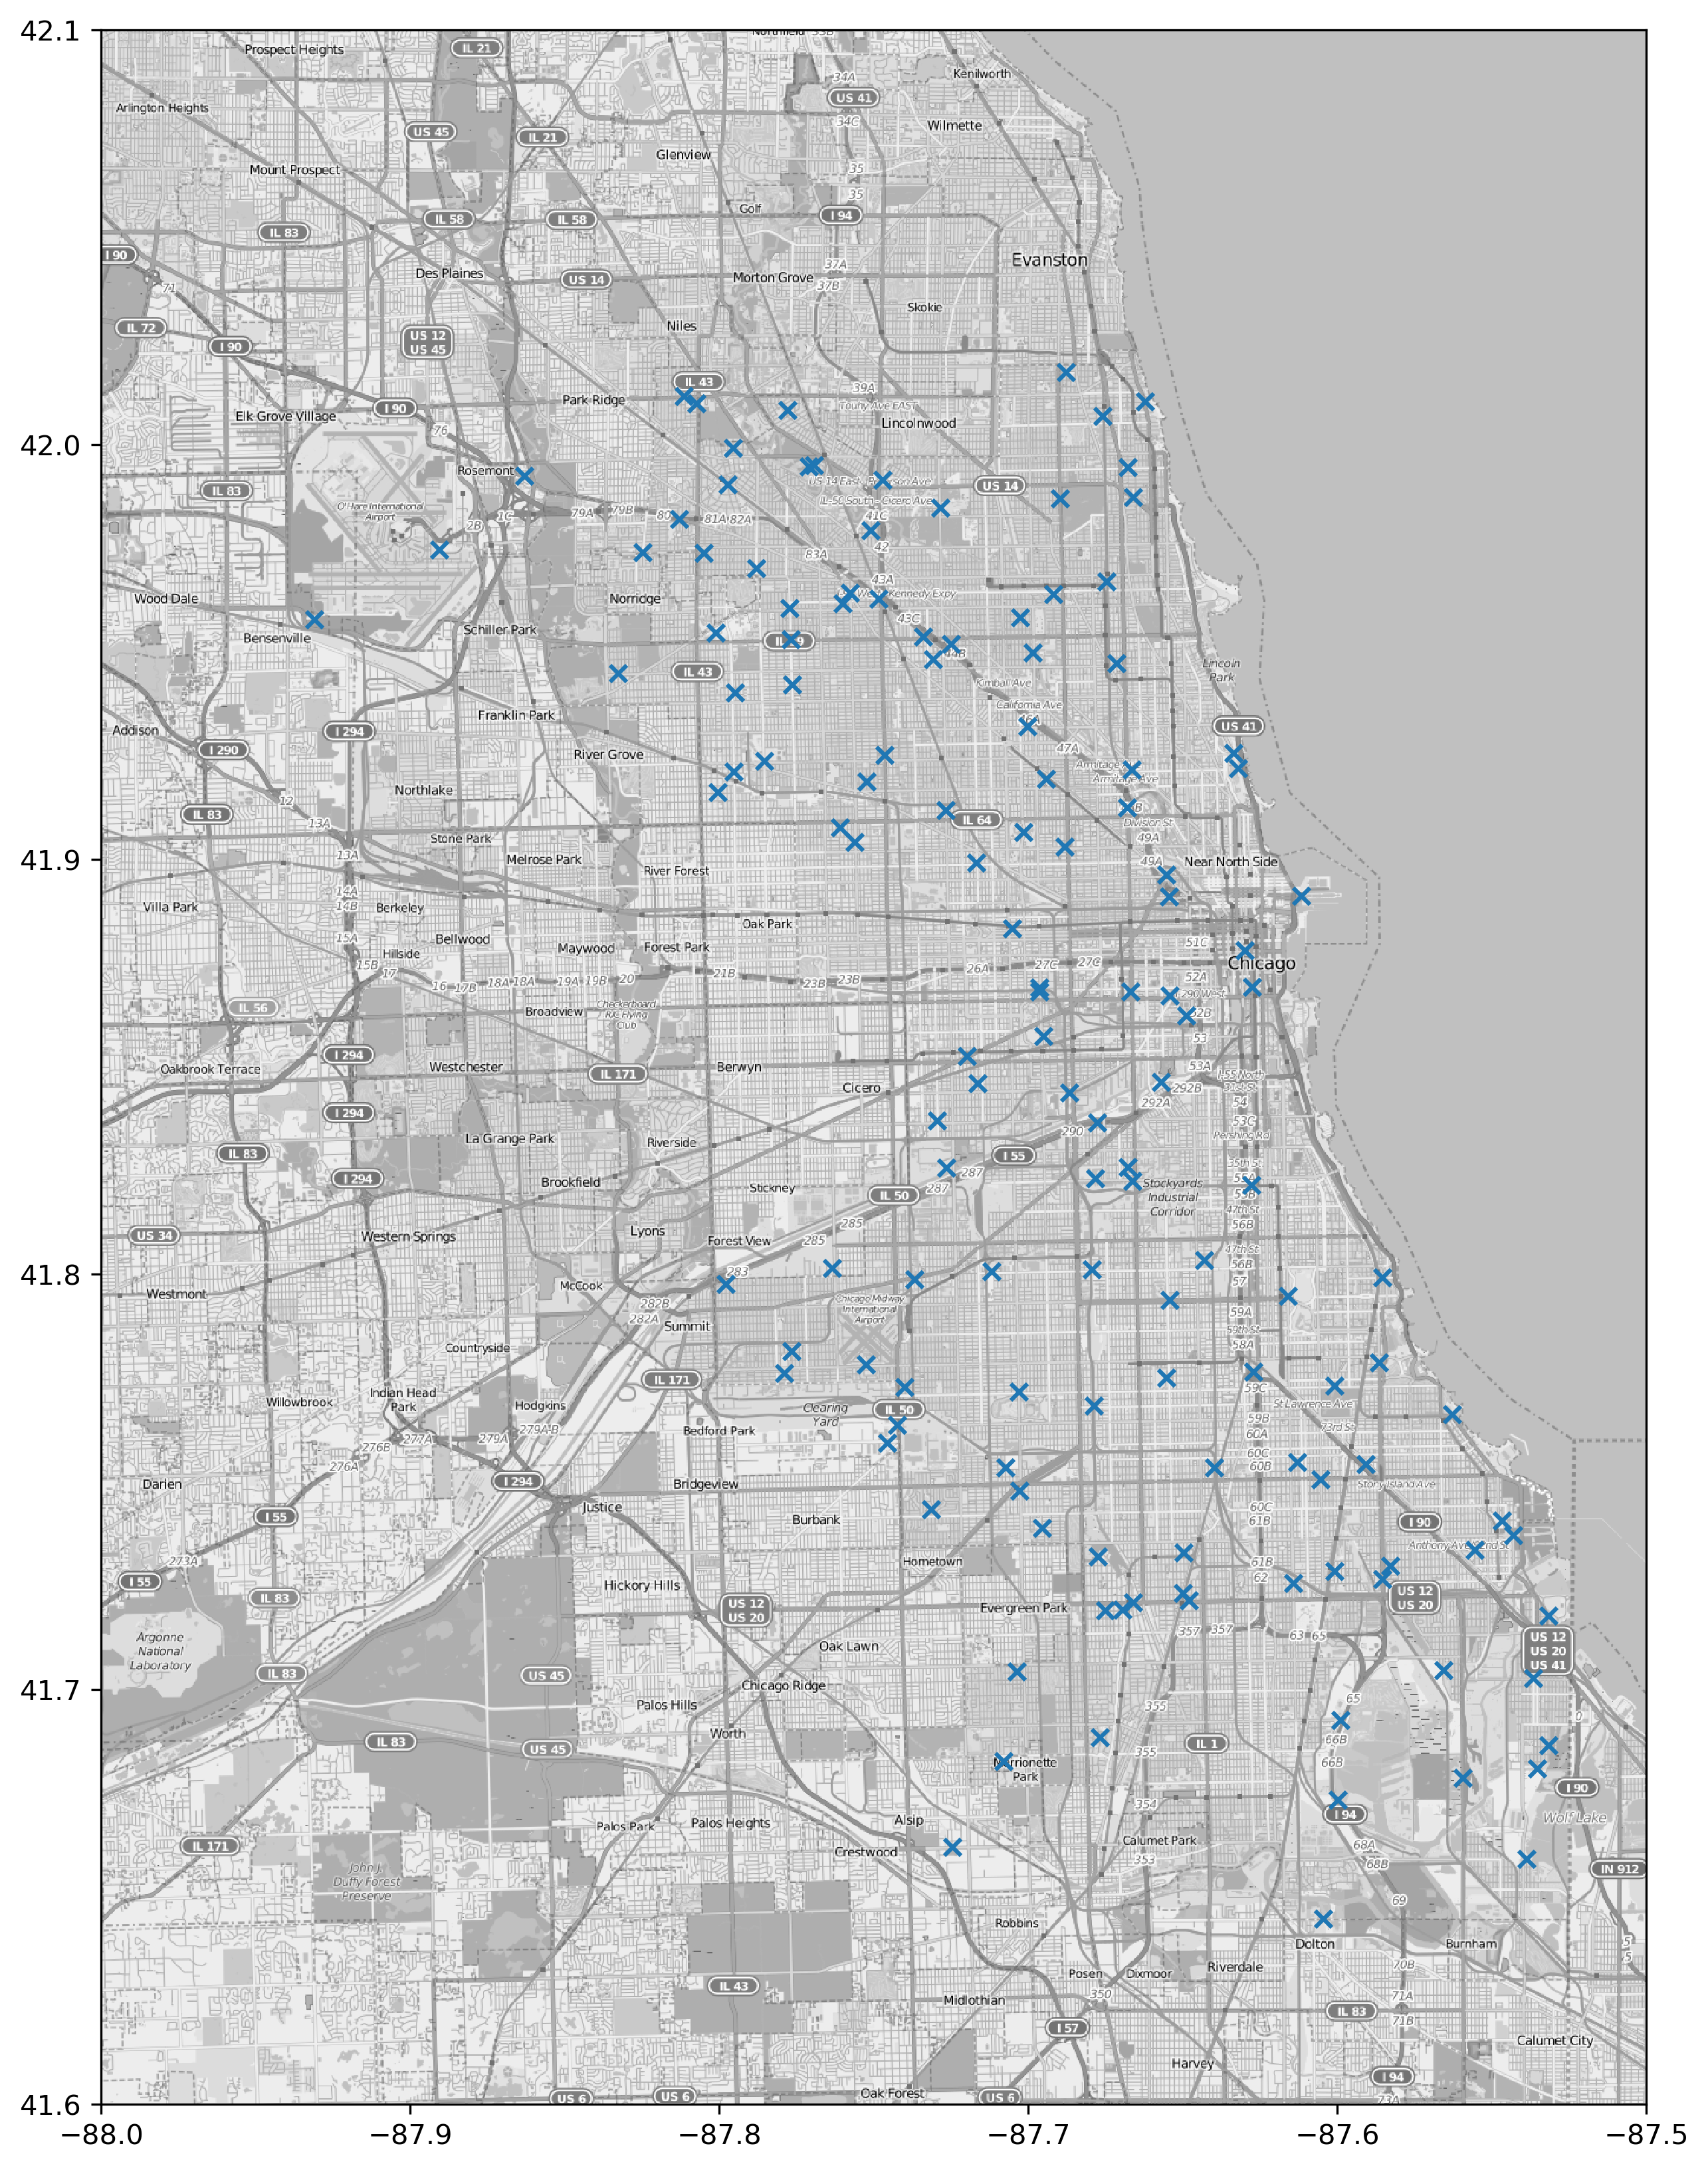

In [580]:
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations = traps[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='x')

#Add this when copying to a script on Kaggle:
#plt.savefig('heatmap.png')

## Traps data cleaning

In [581]:
traps.head(3)

Date                 Species  Trap  Longitude   Latitude  \
0  2007-05-29  CULEX PIPIENS/RESTUANS  T002 -87.800991  41.954690   
1  2007-05-29          CULEX RESTUANS  T002 -87.800991  41.954690   
2  2007-05-29          CULEX RESTUANS  T007 -87.769279  41.994991   

   NumMosquitos  WnvPresent  
0             1           0  
1             1           0  
2             1           0

In [582]:
# Traps df cleaning
# Convert to date to date time
traps.Date = pd.to_datetime(traps.Date)
weather.Date = pd.to_datetime(weather.Date)
# Convert lat&long, num mosquitoes and WnvPResent to numeric
for i in range(3,len(traps.columns)):
    traps.iloc[:, i] = pd.to_numeric(traps.iloc[:, i], errors="coerce")

# Weather df cleaning
# Converts T(trace) to low value of 0.001, and converts "M" (missing data) to NaN
weather["PrecipTotal"] = pd.to_numeric(weather.PrecipTotal.str.strip().replace("T",0.001),
                                      errors="coerce")
# Depart, Cool, Sunrise & Sunset, and PrecipTotal have Missing values
# Convert to numeric first, then forward fill NaN
for i in range(2,len(weather.columns)):
    weather.iloc[:, i] = pd.to_numeric(weather.iloc[:, i], errors="coerce")
# Impute missing values for the weather with forward fill()
weather.fillna(method='ffill',inplace=True)

In [583]:
traps.isnull().sum()

Date            0
Species         0
Trap            0
Longitude       0
Latitude        0
NumMosquitos    0
WnvPresent      0
dtype: int64

In [584]:
def closer_station(lat,long):
    loc = np.array([lat,long])
    # station 1: [41.995, -87.933], station 2: [41.786, -87.752]
    stations = np.array([[41.995, -87.933],
                         [41.786, -87.752]])
    # get the station # with the lower distance squared
    return np.argmin(((stations-loc[None,:])**2).sum(1))+1

In [585]:
def merge_station(traps):
    station_list= []
    for i in range(len(traps)):
        station_dict = {'Trap':traps.loc[i, "Trap"],'Station': closer_station(
                traps.loc[i,"Latitude"], traps.loc[i, "Longitude"])}
        if station_dict not in station_list:
            station_list.append(station_dict) 
    return traps.merge(pd.DataFrame(station_list),on="Trap",how="inner")
trap_stations = merge_station(traps).drop(["Longitude","Latitude"],1)
trap_stations.head()

Date                 Species  Trap  NumMosquitos  WnvPresent  Station
0 2007-05-29  CULEX PIPIENS/RESTUANS  T002             1           0        1
1 2007-05-29          CULEX RESTUANS  T002             1           0        1
2 2007-06-05  CULEX PIPIENS/RESTUANS  T002             3           0        1
3 2007-06-05          CULEX RESTUANS  T002             5           0        1
4 2007-06-05           CULEX PIPIENS  T002             1           0        1

In [434]:
trap_stations.Date[0].month,trap_stations.Date[0].day

(5, 29)

In [435]:
#len(traps)
trap_stations.head(7)

Date                 Species  Trap  NumMosquitos  WnvPresent  Station
0 2007-05-29  CULEX PIPIENS/RESTUANS  T002             1           0        1
1 2007-05-29          CULEX RESTUANS  T002             1           0        1
2 2007-06-05  CULEX PIPIENS/RESTUANS  T002             3           0        1
3 2007-06-05          CULEX RESTUANS  T002             5           0        1
4 2007-06-05           CULEX PIPIENS  T002             1           0        1
5 2007-06-26  CULEX PIPIENS/RESTUANS  T002             1           0        1
6 2007-06-26          CULEX RESTUANS  T002             4           0        1

In [436]:
merged = trap_stations.merge(weather,on=["Date","Station"],how="inner")

In [437]:
merged.head()

Date                 Species  Trap  NumMosquitos  WnvPresent  Station  \
0 2007-05-29  CULEX PIPIENS/RESTUANS  T002             1           0        1   
1 2007-05-29          CULEX RESTUANS  T002             1           0        1   
2 2007-05-29          CULEX RESTUANS  T007             1           0        1   
3 2007-05-29  CULEX PIPIENS/RESTUANS  T015             1           0        1   
4 2007-05-29          CULEX RESTUANS  T015             4           0        1   

   Tmax  Tmin  Tavg  Depart  DewPoint  WetBulb  Heat  Cool  Sunrise  Sunset  \
0    88    60  74.0    10.0        58     65.0   0.0   9.0    421.0  1917.0   
1    88    60  74.0    10.0        58     65.0   0.0   9.0    421.0  1917.0   
2    88    60  74.0    10.0        58     65.0   0.0   9.0    421.0  1917.0   
3    88    60  74.0    10.0        58     65.0   0.0   9.0    421.0  1917.0   
4    88    60  74.0    10.0        58     65.0   0.0   9.0    421.0  1917.0   

   PrecipTotal  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0

# Generate Time Lag

In [593]:
# Make deep copies of stations with different time lags
trap_station_0 = trap_stations.copy()
trap_station_1 = trap_stations.copy()
trap_station_3 = trap_stations.copy()
trap_station_7 = trap_stations.copy()
trap_station_9 = trap_stations.copy()
trap_station_14 = trap_stations.copy()

# for days_ago in [0,1,3,5,8,12]:
#     trap_stationsday = date - dt.timedelta(days=days_ago)

In [604]:
days_ago = [0,1,3,7,9,14]
station_list = []
for i in range(len(days_ago)):
    station_list.append(trap_stations.copy())
for i in range(len(days_ago)):
    station_list[i].Date = station_list[i].Date - dt.timedelta(days = days_ago[i])
#station_list

In [605]:
merged_list = []
for station in station_list:
    merged_list.append(station.merge(weather,on=["Date","Station"],how="inner"))

In [606]:
merged_list

[            Date                 Species  Trap  NumMosquitos  WnvPresent  \
 0     2007-05-29  CULEX PIPIENS/RESTUANS  T002             1           0   
 1     2007-05-29          CULEX RESTUANS  T002             1           0   
 2     2007-05-29          CULEX RESTUANS  T007             1           0   
 3     2007-05-29  CULEX PIPIENS/RESTUANS  T015             1           0   
 4     2007-05-29          CULEX RESTUANS  T015             4           0   
 5     2007-05-29  CULEX PIPIENS/RESTUANS  T143             1           0   
 6     2007-06-05  CULEX PIPIENS/RESTUANS  T002             3           0   
 7     2007-06-05          CULEX RESTUANS  T002             5           0   
 8     2007-06-05           CULEX PIPIENS  T002             1           0   
 9     2007-06-05  CULEX PIPIENS/RESTUANS  T015             1           0   
 10    2007-06-05          CULEX RESTUANS  T015             2           0   
 11    2007-06-05  CULEX PIPIENS/RESTUANS  T143             2           0   

# Modeling

In [659]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score

In [660]:
merged2 = pd.get_dummies(merged,columns=["Species","Trap"]).drop(["Date","NumMosquitos"],1)
y = merged2.WnvPresent
X = merged2.drop(["WnvPresent"],1)
Xt, Xhold, yt, yhold = train_test_split(X, y, test_size=0.2)


In [665]:
merged2 = pd.get_dummies(merged_list[1],columns=["Species","Trap"]).drop(["Date","NumMosquitos"],1)
y = merged2.WnvPresent
X = merged2.drop(["WnvPresent"],1)
Xt, Xhold, yt, yhold = train_test_split(X, y, test_size=0.2)


In [666]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics
def quick_test(model, X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
    model.fit(xtrain, ytrain)
    return model.score(xtest, ytest)
def f1_multi(model, X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
    fit = model.fit(xtrain, ytrain)
    pred = fit.predict(xtest)
    return f1_score(ytest, pred)
def auc_test(model, X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
    fit = model.fit(xtrain, ytrain)
    pred = fit.predict(xtest)
    fpr, tpr, thresholds = metrics.roc_curve(ytest, pred, pos_label=2)
    return metrics.auc(fpr, tpr)


def quick_test_afew_times(model, X, y, n=10):
    return np.mean([f1_multi(model, X, y) for j in range(n)])

In [672]:
#xtrain, xtest, ytrain, ytest = train_test_split(Xt, yt, test_size=0.3)
linearsvc = LinearSVC()
decisiontree = DecisionTreeClassifier()
randomforest = RandomForestClassifier()
decisiontree = DecisionTreeClassifier()
blagging = BaggingClassifier()
log = LogisticRegression()
dummy = DummyClassifier()
# fit = randomforest.fit(xtrain, ytrain)
# pred = fit.predict(xtest)
quick_test_afew_times(decisiontree, Xt, yt)

0.1928133672907013

In [671]:
quick_test(dummy, Xt, yt)

0.8957176843774782

In [443]:
randomforest = RandomForestClassifier()
quick_test_afew_times(randomforest, X, y)
f1_test(randomforest,X,y)

0.15458937198067632

In [444]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
model_svm = svm.SVC(kernel='rbf', gamma = 0.001)
model_svm.fit(X_train, y_train)
y_pred = model_svm.predict(X_test)
f1_test(svm.SVC(kernel='rbf', gamma = 0.001),X,y)

/Users/petermin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

Text(0,0.5,'TPR')

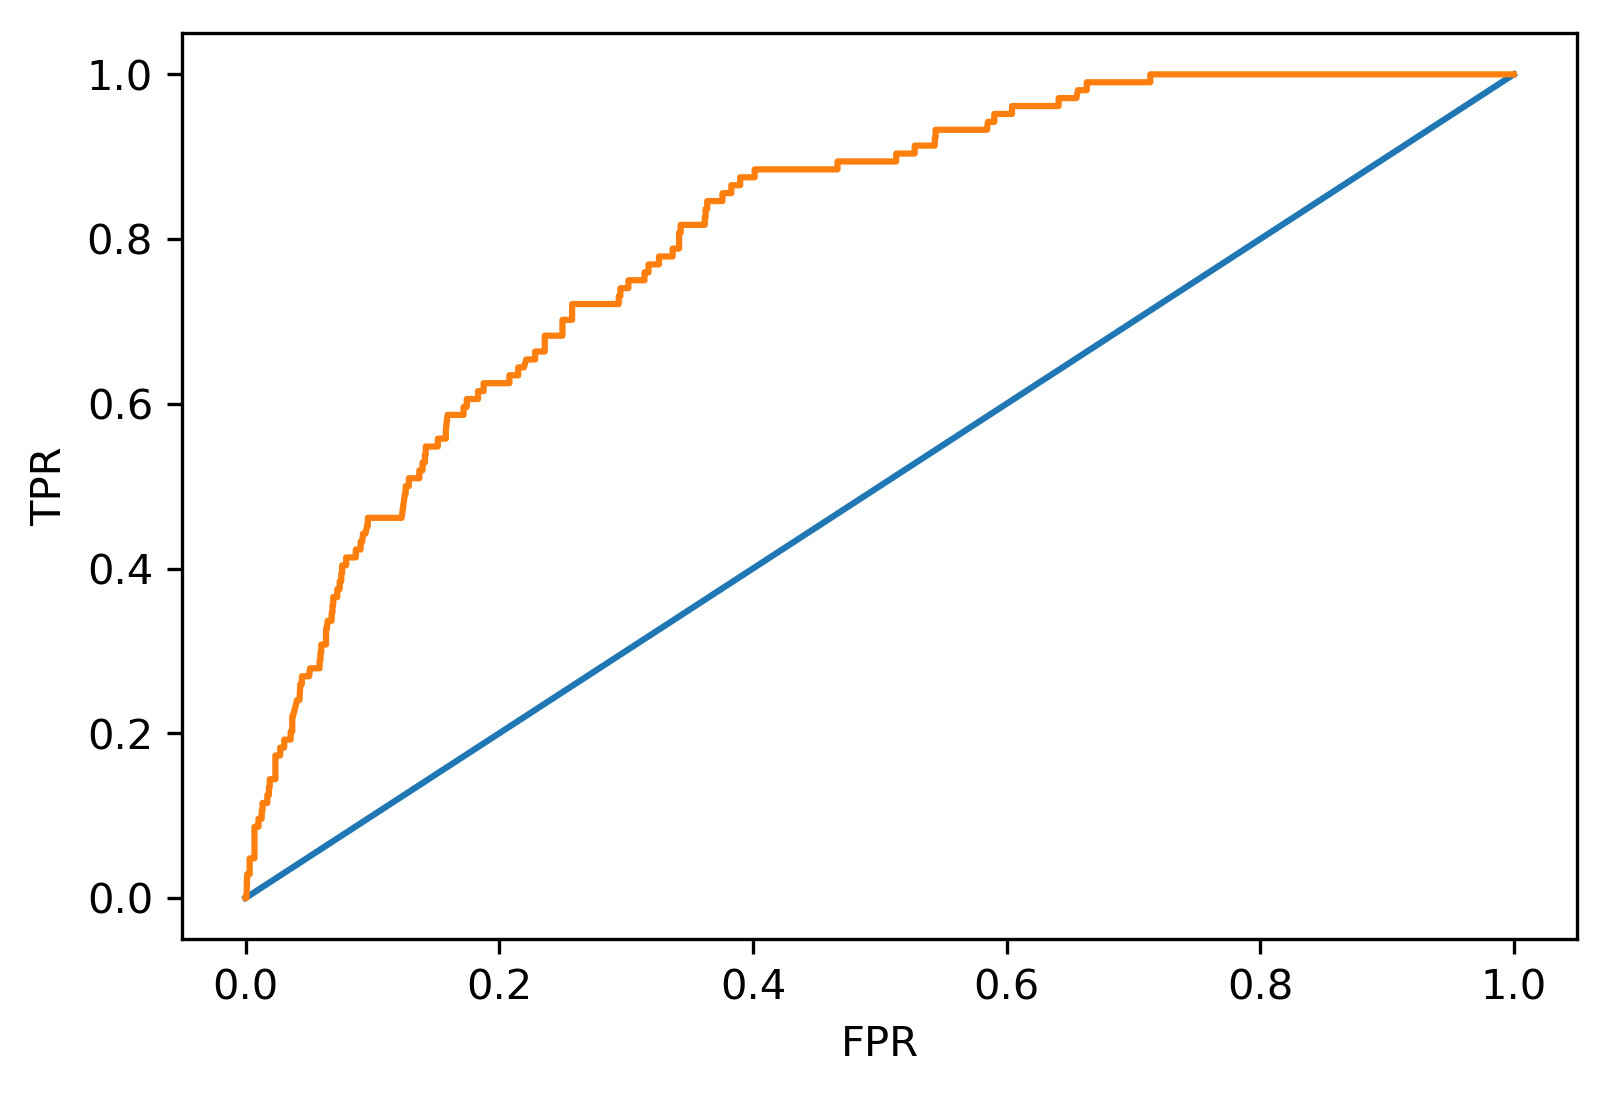

In [611]:
from sklearn.metrics import roc_curve, auc
from patsy import dmatrices

from sklearn import linear_model as lm
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import confusion_matrix

xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(Xt, yt, test_size=0.2, random_state=1234)
log = LogisticRegression()
log.fit(xtrain,np.ravel(ytrain))
y_score=log.predict_proba(xtest)[:,1]

fpr, tpr,_ = roc_curve(ytest, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

In [446]:
# Generate a confusion matrix plot: 

def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Could be a typical function for classifying:

def train_score(classifier,x,y):
    xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(x, y, test_size=0.2, random_state=1234)
    ytrain=np.ravel(ytrain)
    clf = classifier.fit(xtrain, ytrain)
    # accuracy for test & train:
    train_acc=clf.score(xtrain, ytrain)
    test_acc=clf.score(xtest,ytest)
    print("Training Data Accuracy: %0.2f" %(train_acc))
    print("Test Data Accuracy:     %0.2f" %(test_acc))
    
    y_true = ytest
    y_pred = clf.predict(xtest)


    conf = confusion_matrix(y_true, y_pred)
    print(conf)

    print ('\n')
    print ("Precision:              %0.2f" %(conf[0, 0] / (conf[0, 0] + conf[1, 0])))
    print ("Recall:                 %0.2f"% (conf[0, 0] / (conf[0, 0] + conf[0, 1])))
    
    cm=confusion_matrix(y_true, y_pred, labels=None)
    
    plt.figure()
    plot_confusion_matrix(cm)

In [453]:
from sklearn.metrics import f1_score
log_clf=LogisticRegression()
randomforest = RandomForestClassifier()
linearsvc = LinearSVC()
dummy = DummyClassifier()
f1_test(randomforest, Xt, yt)

0.17894736842105263

# Feature Importance

Feature ranking:
1. feature 10 (0.049720)
2. feature 9 (0.042792)
3. feature 1 (0.035133)
4. feature 3 (0.033249)
5. feature 14 (0.032886)
6. feature 13 (0.031793)
7. feature 2 (0.030062)
8. feature 5 (0.028482)
9. feature 4 (0.027488)
10. feature 6 (0.026922)
11. feature 8 (0.026507)
12. feature 100 (0.019069)
13. feature 30 (0.018896)
14. feature 61 (0.017155)
15. feature 11 (0.017126)
16. feature 153 (0.016813)
17. feature 15 (0.015564)
18. feature 87 (0.014664)
19. feature 20 (0.014044)
20. feature 26 (0.013690)
21. feature 39 (0.012702)
22. feature 28 (0.012347)
23. feature 38 (0.012335)
24. feature 21 (0.012092)
25. feature 149 (0.011877)
26. feature 120 (0.011707)
27. feature 41 (0.011323)
28. feature 145 (0.010961)
29. feature 40 (0.010693)
30. feature 101 (0.010393)
31. feature 0 (0.010368)
32. feature 80 (0.009358)
33. feature 108 (0.009313)
34. feature 102 (0.008895)
35. feature 104 (0.008813)
36. feature 143 (0.008742)
37. feature 58 (0.008470)
38. feature 29 (0.008240)
39.

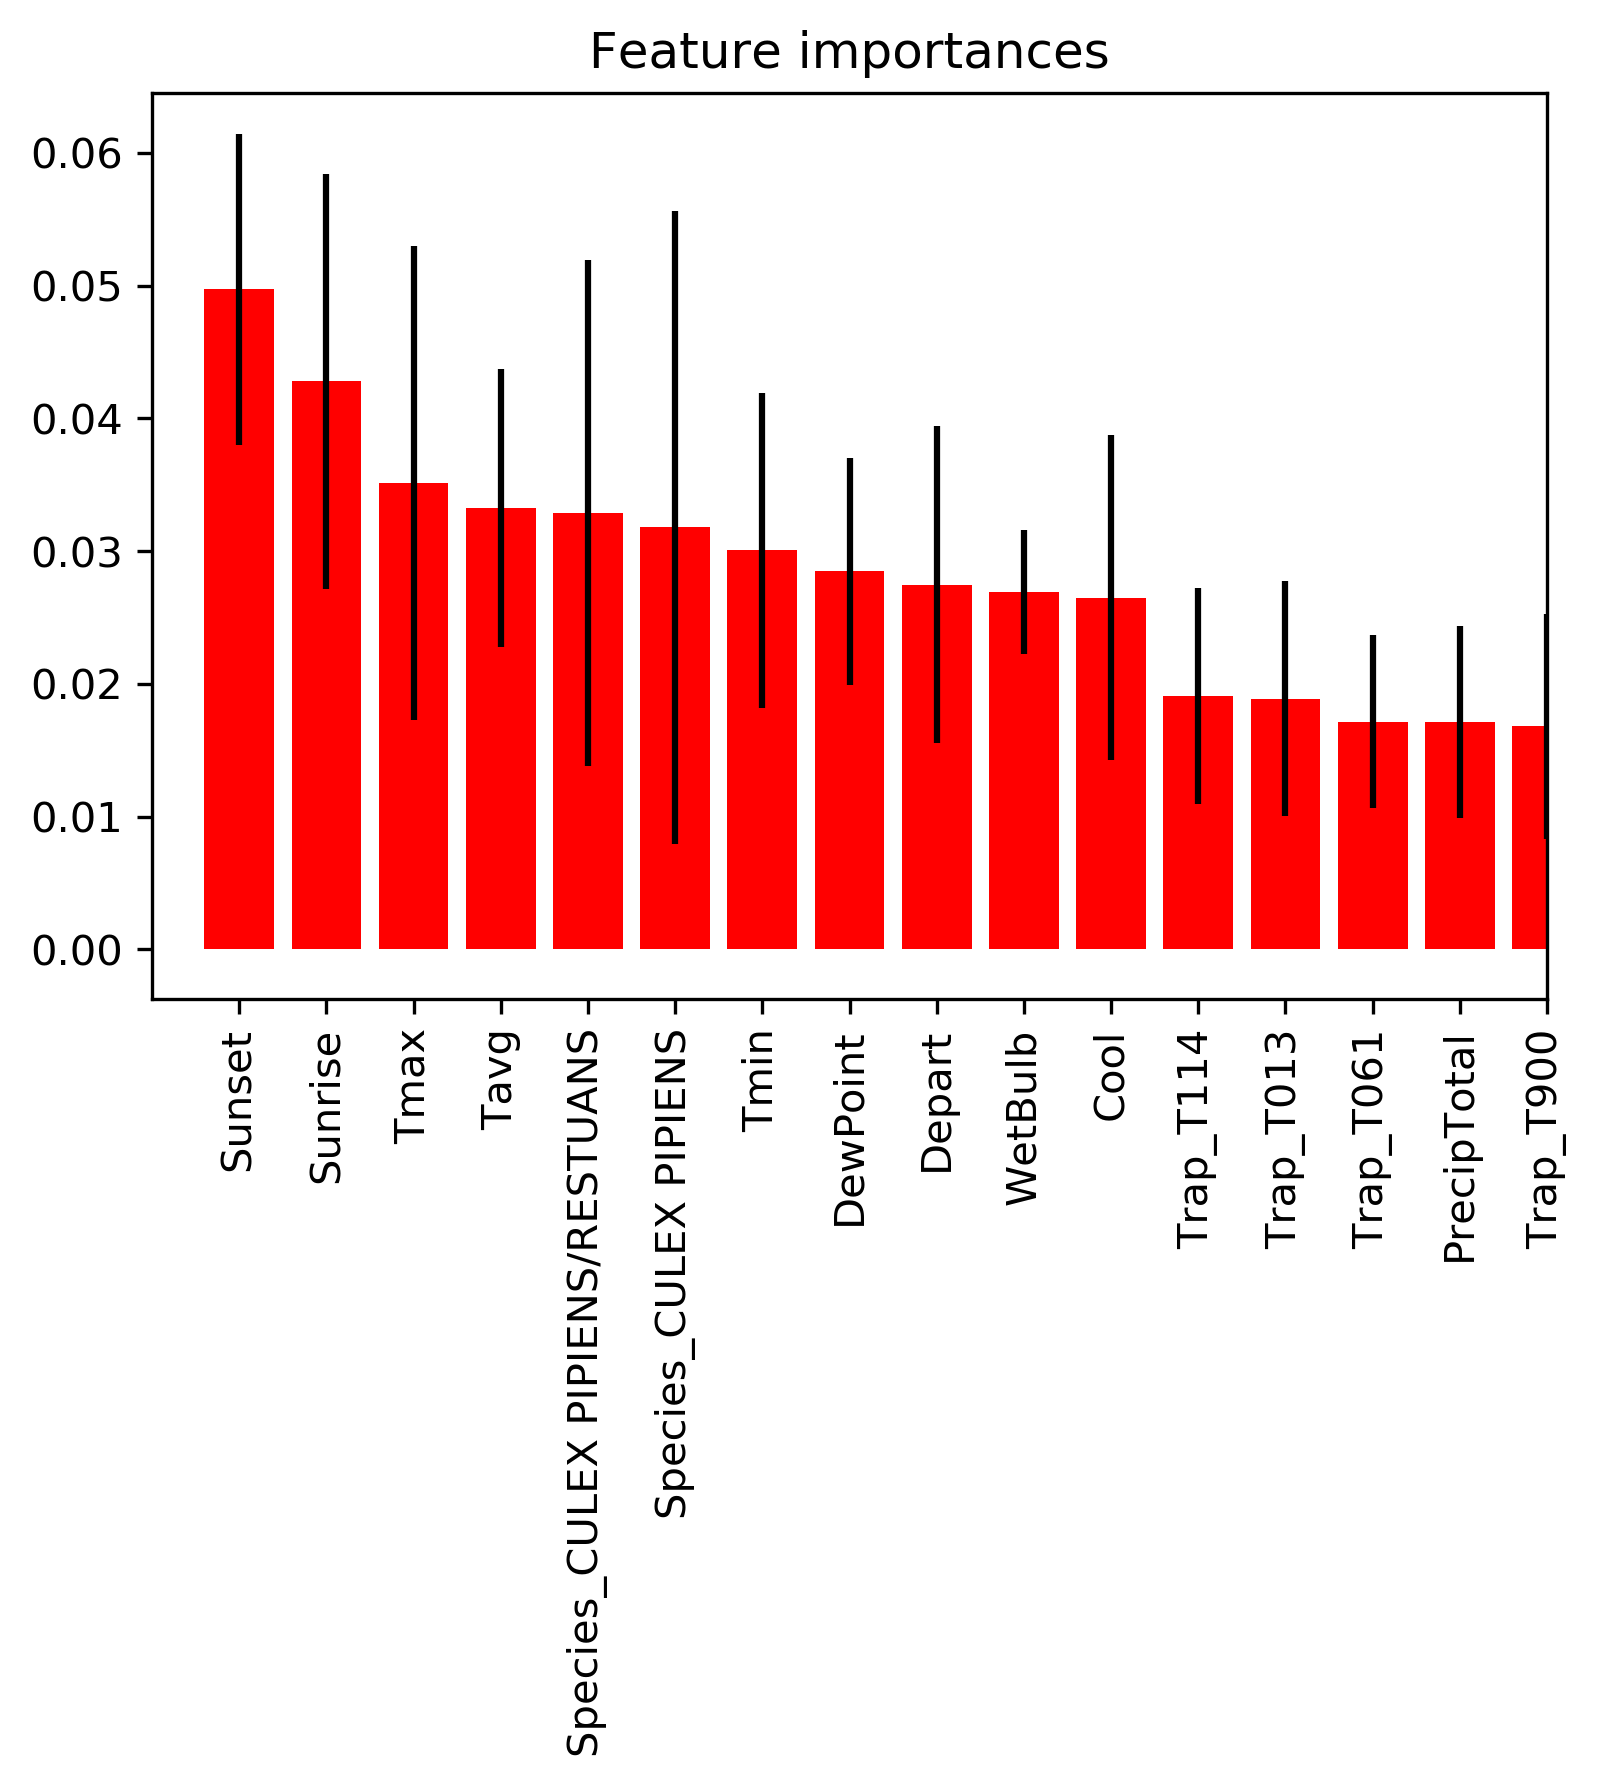

In [468]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
randomforest.fit(xtrain, ytrain)
importances = randomforest.feature_importances_
std = np.std([tree.feature_importances_ for tree in randomforest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(xtrain.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(xtrain.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(xtrain.shape[1]), xtrain.columns[indices], rotation="vertical")
plt.xlim([-1, 15])
plt.show()

In [474]:
xtrain.columns[0]

'Station'

# Time series analysis (figuring out time lag)

In [475]:
#Depart, Cool, Sunrise & Sunset, and PrecipTotal have Missing values
weather.Tavg.unique()

array([67., 68., 51., 52., 56., 58., 60., 59., 65., 70., 69., 71., 61.,
       55., 57., 73., 72., 53., 62., 63., 74., 75., 78., 76., 77., 66.,
       80., 64., 81., 82., 79., 85., 84., 83., 50., 49., 46., 48., 45.,
       54., 47., 44., 40., 41., 38., 39., 42., 37., 43., 86., 87., 89.,
       92., 88., 91., 93., 94., 90., 36.])

In [476]:
traps.columns

Index(['Date', 'Species', 'Trap', 'Longitude', 'Latitude', 'NumMosquitos',
       'WnvPresent'],
      dtype='object')

In [504]:
traps_2009 = traps[(traps.Date < dt.date(2010,1,1)) & (traps.Date > dt.date(2009,1,1))]
weather_2009 = weather[(weather.Date < dt.date(2010,1,1)) & (weather.Date > dt.date(2009,1,1))]
traps_2011 = traps[(traps.Date < dt.date(2012,1,1)) & (traps.Date > dt.date(2011,1,1))]
weather_2011 = weather[(weather.Date < dt.date(2012,1,1)) & (weather.Date > dt.date(2011,1,1))]

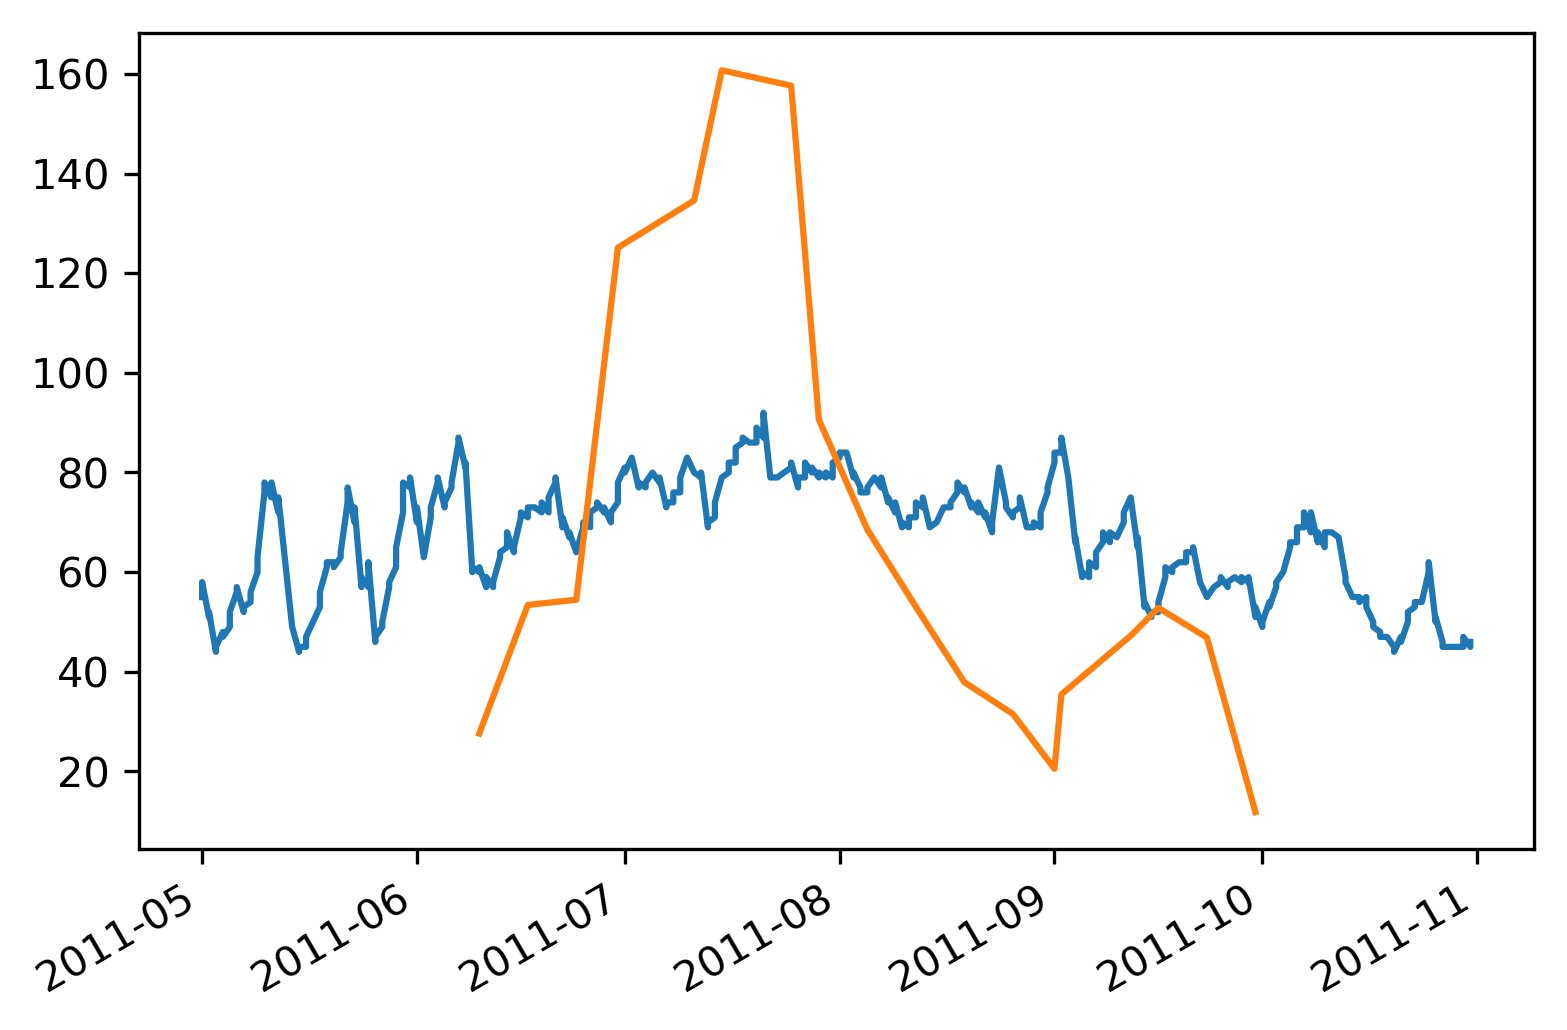

In [478]:
# dates = dates.date2num(weather.Date)
# plt.plot_date(dates, weather.Tavg)
plt.plot(weather[(weather.Date < dt.date(2012,1,1)) & 
                 (weather.Date > dt.date(2011,1,1))].Date,
        weather[(weather.Date < dt.date(2012,1,1)) & 
                (weather.Date > dt.date(2011,1,1))].Tavg)

plt.plot(traps_2011.groupby('Date').agg('sum').index, 
         traps_2011.groupby('Date').agg('sum').NumMosquitos/Scale)
plt.gcf().autofmt_xdate()

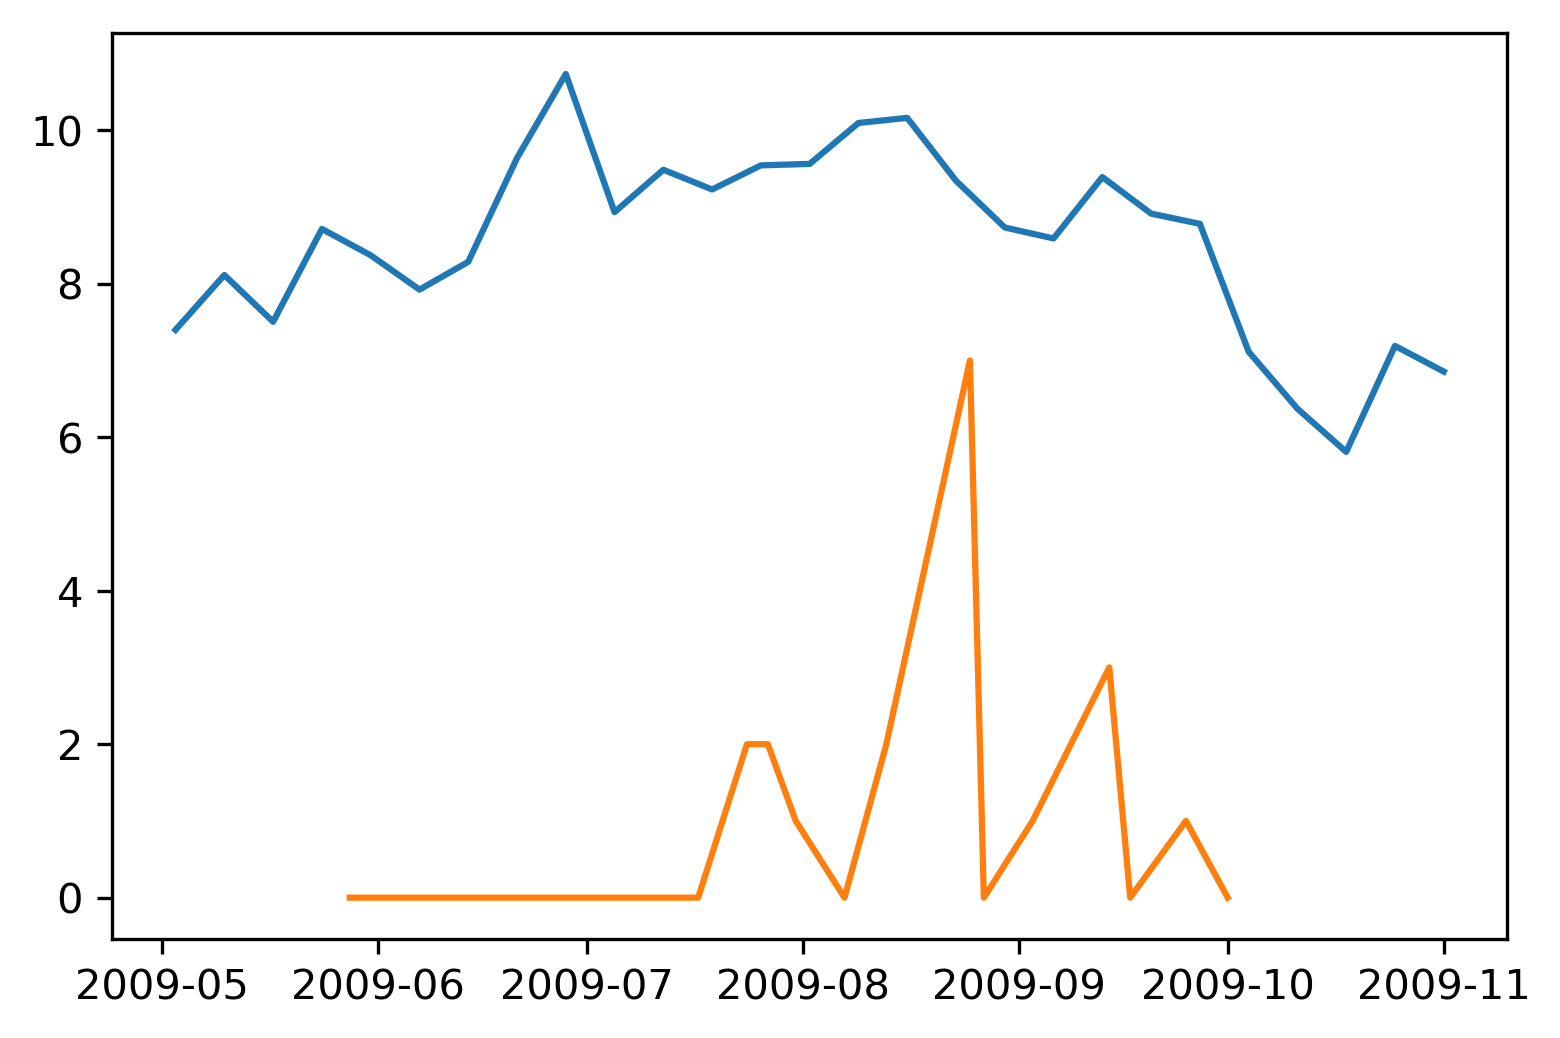

In [506]:
weekly_2009 = weather_2009.set_index("Date").Tavg.resample('W').mean()
plt.plot(weekly_2009 / 7.5)
plt.plot(traps_2009.groupby('Date').agg('sum').index, 
         traps_2009.groupby('Date').agg('sum').WnvPresent)


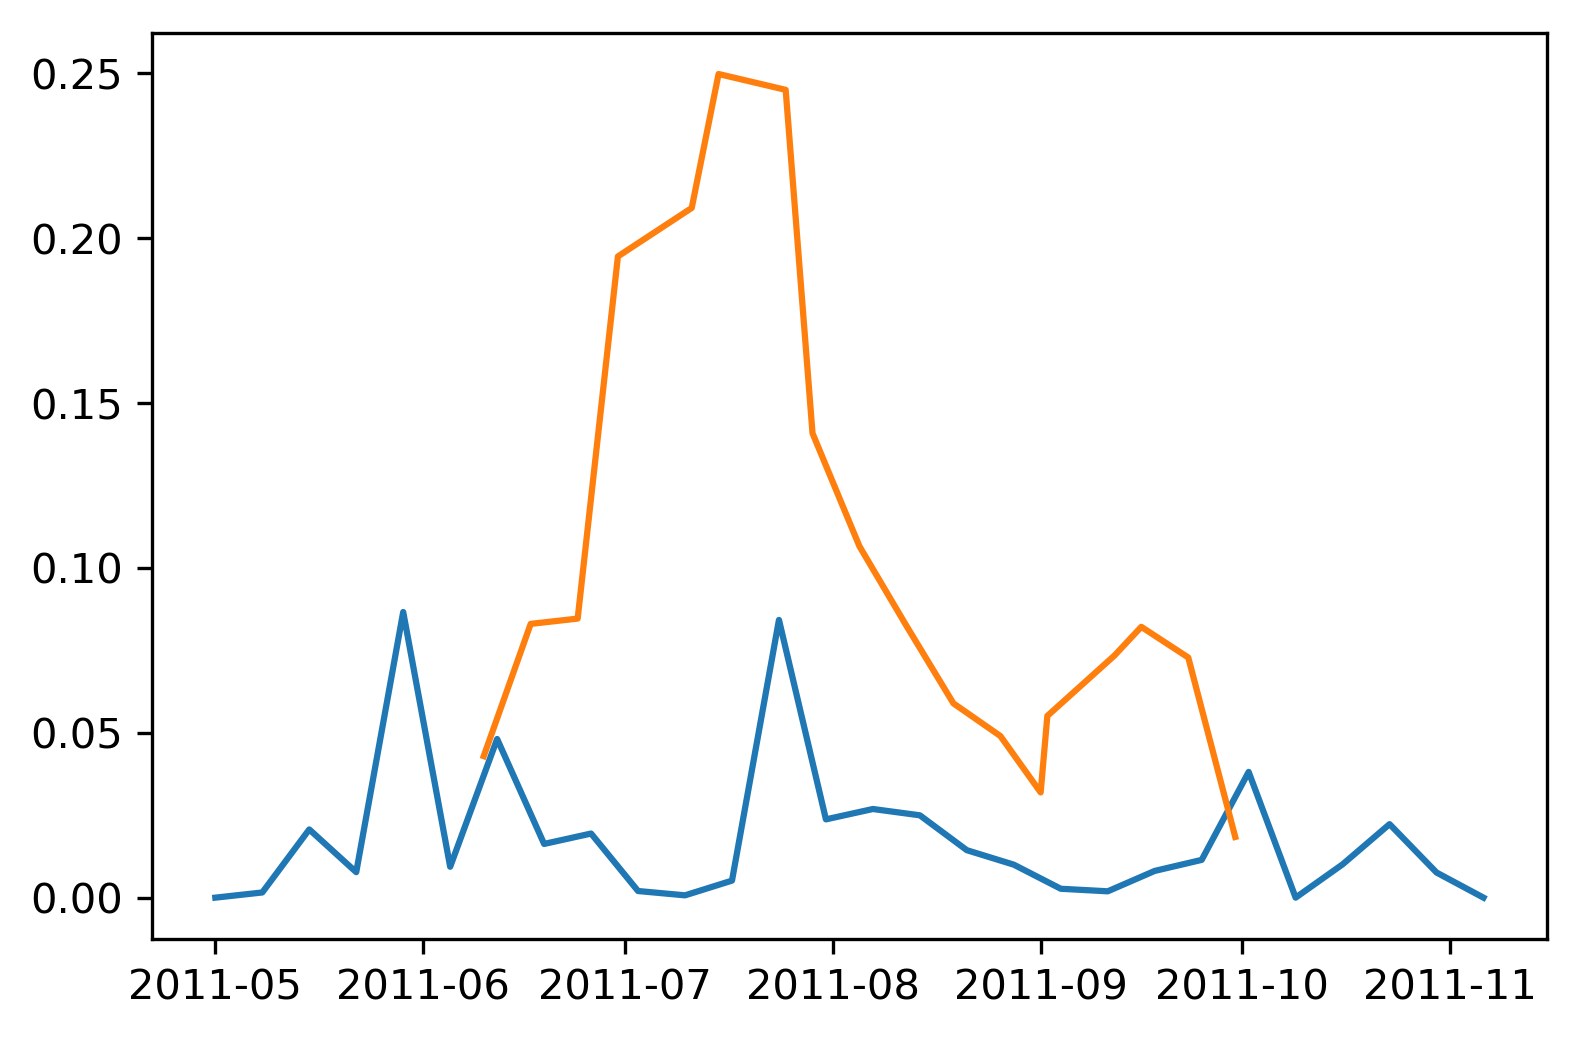

In [556]:
weekly_2011 = weather_2011.set_index("Date").PrecipTotal.resample('W').mean()
plt.plot(weekly_2011 / 7.5)
plt.plot(traps_2011.groupby('Date').agg('sum').index, 
         traps_2011.groupby('Date').agg('sum').NumMosquitos/10000)


In [495]:

#weather2 = weather.set_index("Date")
weathermax_2011 = weather_2011.set_index("Date").Tavg.resample('W').mean().max()
trapsmax_2011 = traps_2011.groupby('Date').agg('sum').WnvPresent.max()
weathermax_2011

83.92857142857143

In [549]:
weather_2011.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'PrecipTotal'],
      dtype='object')

In [494]:
#traps_2011[traps_2011.groupby('Date').agg('sum').WnvPresent == trapsmax_2011]
#traps_2011.groupby('Date').agg('sum').WnvPresent
weather_2011.set_index("Date").Tavg.resample('W').mean()

Date
2011-05-01    56.500000
2011-05-08    51.142857
2011-05-15    63.428571
2011-05-22    58.928571
2011-05-29    57.928571
2011-06-05    73.071429
2011-06-12    68.857143
2011-06-19    69.142857
2011-06-26    70.500000
2011-07-03    76.285714
2011-07-10    77.857143
2011-07-17    77.857143
2011-07-24    83.928571
2011-07-31    80.000000
2011-08-07    79.571429
2011-08-14    71.785714
2011-08-21    73.785714
2011-08-28    72.785714
2011-09-04    75.785714
2011-09-11    64.928571
2011-09-18    59.928571
2011-09-25    59.714286
2011-10-02    55.500000
2011-10-09    65.428571
2011-10-16    60.500000
2011-10-23    48.500000
2011-10-30    49.571429
2011-11-06    45.500000
Freq: W-SUN, Name: Tavg, dtype: float64

In [503]:
dt.date(2011,8,14)-dt.date(2011,7,24)

datetime.timedelta(21)

In [501]:
tweekly_2011 = traps_2011.groupby('Date').agg('sum').WnvPresent.resample('W', fill_method='ffill')
tweekly_2011

/Users/petermin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).ffill()
  """Entry point for launching an IPython kernel.


Date
2011-06-12     0
2011-06-19     0
2011-06-26     0
2011-07-03     0
2011-07-10     0
2011-07-17     0
2011-07-24     0
2011-07-31     8
2011-08-07     5
2011-08-14    11
2011-08-21     4
2011-08-28     4
2011-09-04     3
2011-09-11     3
2011-09-18     3
2011-09-25     6
2011-10-02     0
Freq: W-SUN, Name: WnvPresent, dtype: int64

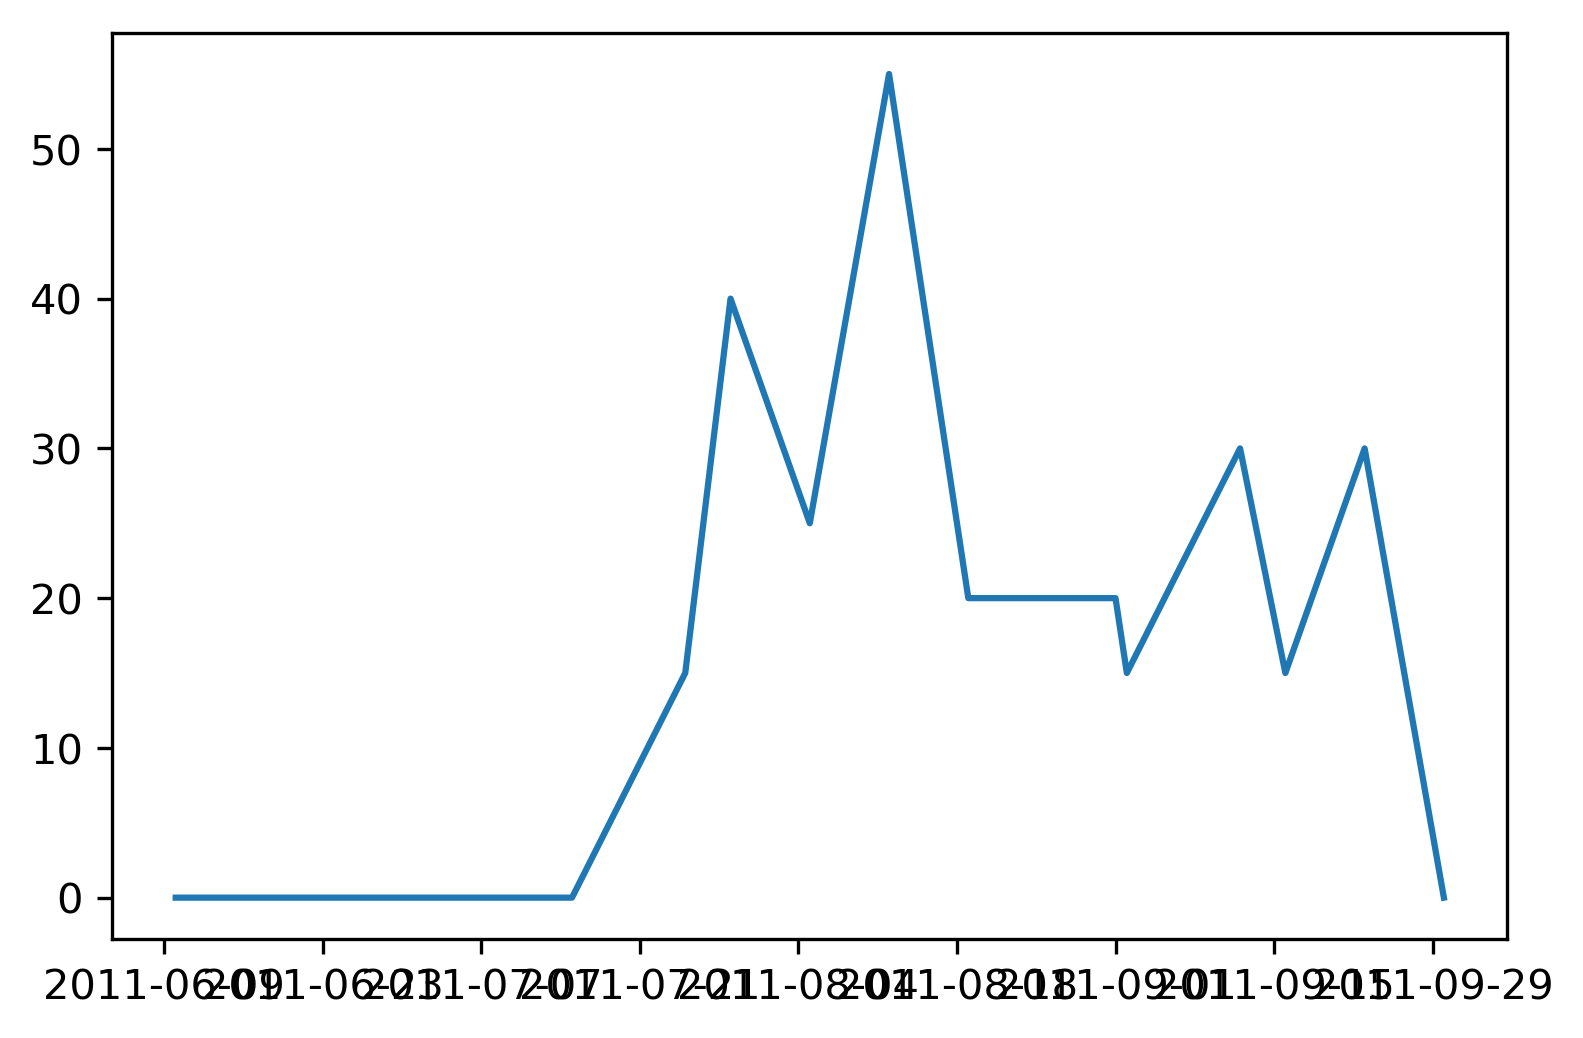

In [331]:
plt.plot(traps_2011.groupby('Date').agg('sum').index, 
         traps_2011.groupby('Date').agg('sum').WnvPresent*5)

In [110]:
traps_2011.groupby('Date').agg('sum').index, traps_2011.groupby('Date').agg('sum').WnvPresent

(DatetimeIndex(['2011-06-10', '2011-06-17', '2011-06-24', '2011-06-30',
                '2011-07-11', '2011-07-15', '2011-07-25', '2011-07-29',
                '2011-08-05', '2011-08-12', '2011-08-19', '2011-08-26',
                '2011-09-01', '2011-09-02', '2011-09-12', '2011-09-16',
                '2011-09-23', '2011-09-30'],
               dtype='datetime64[ns]', name='Date', freq=None), Date
 2011-06-10     0
 2011-06-17     0
 2011-06-24     0
 2011-06-30     0
 2011-07-11     0
 2011-07-15     0
 2011-07-25     3
 2011-07-29     8
 2011-08-05     5
 2011-08-12    11
 2011-08-19     4
 2011-08-26     4
 2011-09-01     4
 2011-09-02     3
 2011-09-12     6
 2011-09-16     3
 2011-09-23     6
 2011-09-30     0
 Name: WnvPresent, dtype: int64)

In [111]:
traps_2011.groupby('Date').agg('sum').WnvPresent

Date
2011-06-10     0
2011-06-17     0
2011-06-24     0
2011-06-30     0
2011-07-11     0
2011-07-15     0
2011-07-25     3
2011-07-29     8
2011-08-05     5
2011-08-12    11
2011-08-19     4
2011-08-26     4
2011-09-01     4
2011-09-02     3
2011-09-12     6
2011-09-16     3
2011-09-23     6
2011-09-30     0
Name: WnvPresent, dtype: int64

In [77]:
weather[(weather.Date < dt.date(2010,1,1)) & (weather.Date > dt.date(2009,1,1))].Date.head()

736   2009-05-01
737   2009-05-01
738   2009-05-02
739   2009-05-02
740   2009-05-03
Name: Date, dtype: datetime64[ns]

In [216]:
weather.head()

Station        Date  Tmax  Tmin Tavg Depart  DewPoint WetBulb Heat Cool  \
0        1  2007-05-01    83    50   67     14        51      56    0    2   
1        2  2007-05-01    84    52   68      M        51      57    0    3   
2        1  2007-05-02    59    42   51     -3        42      47   14    0   
3        2  2007-05-02    60    43   52      M        42      47   13    0   
4        1  2007-05-03    66    46   56      2        40      48    9    0   

     ...    CodeSum Depth Water1 SnowFall PrecipTotal StnPressure SeaLevel  \
0    ...                0      M      0.0        0.00       29.10    29.82   
1    ...                M      M        M        0.00       29.18    29.82   
2    ...         BR     0      M      0.0        0.00       29.38    30.09   
3    ...      BR HZ     M      M        M        0.00       29.44    30.08   
4    ...                0      M      0.0        0.00       29.39    30.12   

  ResultSpeed ResultDir  AvgSpeed  
0         1.7        27       9.2  
1         2.7        25       9.6  
2        13.0         4      13.4  
3        13.3         2      13.4  
4        11.7         7      11.9  

[5 rows x 22 columns]

In [79]:
traps_2009.groupby('Date').agg('sum').index

DatetimeIndex(['2009-05-28', '2009-06-02', '2009-06-03', '2009-06-05',
               '2009-06-12', '2009-06-15', '2009-06-19', '2009-06-22',
               '2009-06-26', '2009-06-29', '2009-07-06', '2009-07-10',
               '2009-07-13', '2009-07-17', '2009-07-24', '2009-07-27',
               '2009-07-31', '2009-08-07', '2009-08-13', '2009-08-25',
               '2009-08-27', '2009-09-03', '2009-09-14', '2009-09-17',
               '2009-09-25', '2009-10-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [116]:
# import numpy as np
# from scipy.interpolate import Rbf, InterpolatedUnivariateSpline

# import matplotlib
# matplotlib.use('Agg')
# import matplotlib.pyplot as plt

# # xi = weather[(weather.Date < dt.date(2012,1,1)) & (weather.Date > dt.date(2011,1,1))].Tavg
# # # use fitpack2 method
# # ius = InterpolatedUnivariateSpline(weather[(weather.Date < dt.date(2012,1,1)) & (weather.Date > dt.date(2011,1,1))].Date,
# #         weather[(weather.Date < dt.date(2012,1,1)) & (weather.Date > dt.date(2011,1,1))].Tavg)
# # yi = ius(xi)

# # import statsmodels.api as sm
# # sm.tsa.seasonal_decompose(weather[(weather.Date < dt.date(2012,1,1)) & (weather.Date > dt.date(2011,1,1))].Tavg).plot()
# # result = sm.tsa.stattools.adfuller(weather[(weather.Date < dt.date(2012,1,1)) & (weather.Date > dt.date(2011,1,1))].Date)
# # plt.show()
# Tavg = weather[(weather.Date < dt.date(2012,1,1)) & (weather.Date > dt.date(2011,1,1))].Tavg
# Date = weather[(weather.Date < dt.date(2012,1,1)) & (weather.Date > dt.date(2011,1,1))].Date
# Date.corr(Tavg)